# Modeling Antibiotic Responce Through Datamining in the MIMICIII Dataset
###Garrett Eickelberg with help from Kishore Anekalla, Yikuan Li, Dr. Yuan Luo, Dr. Nelson Sanchez-Pinto

the overarching contents of this notebook will be detailed in my googledoc labnotebook 
https://docs.google.com/document/d/1bJcv0ZUkjVhFga9ZOLMNV6pXR9jLEMQmPhLS93njrCc/edit#

1/21/19
the PAII project version of this cohort generation is gearing to get all patients suspected of having a bacteerial infection. for these patients, we want to find all patients who had a positive BLOOD culture atleast (12?) hours after their first antibiotic dose. 

we will then use data up to 24 hours after this to predict culture results. 

need to extract organism type, and t_sc_plus24


In [8]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import collections
import asyncio
import getpass
import re
from datetime import datetime as dt
import os,sys,re
import urllib3
import prettytable
from collections import Counter
import seaborn as sns
import random
from datetime import timedelta
from pathlib import Path

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

date= '04042019'

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 27.3 ms


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp'", use "location='/tmp'" instead.


#reserach question:
-Can we predict the organism type for pts with positive blood cultures in patients suspected of having an infection with data up to 24 hours after the culture (ie the approximate time we would recieve teh culture result). 

#cohort criteria:
- YES- only adult patients (over 18 yo)  (~n= 38,000 age >18)
- with sterile culture 
- and ab start within the same 24 hours time window.


Three subsets:
– Started on antibiotics, after 48hrs, negculture, discontinue	: neg/stop
- 48hrs, negculture, but continue full course 7, 10, or 14 days: neg/continue
– Positive culture, continue full course.Predict whether kept on antibiotics:

    pos/continue
    
	Infected with positive culture
    
	Infected with negative culture (ie a false positive)
    
    
#components: data cleaning, model building

In [9]:
#code used to ping the postgres mimic server. 

conn = psycopg2.connect(dbname="mimic", user="student", host="luolabwkstn01.fsm.northwestern.edu", port="5432",
                        password=getpass.getpass(prompt='Password:'.format()))
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciii" + ';'

Password: ·····


time: 3.11 s


In [10]:
ABrx = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/02082018_ABrx_updated.csv')



time: 781 ms


# generating patient culture/icu/hospital info


## sterile culture info

In [11]:
###commented this all out and will try to see what the patient icustay id landscape is like with just using blood cultures
#retrieving all patients with sterile culture. this was reverted because the "suspected infection criteria" needs to remain the same

##changed on 4/16/18 to include all hadm_id
sterile_pt_sql = query_schema + """
SELECT row_id, subject_id, hadm_id, chartdate, charttime, spec_itemid, spec_type_desc, org_name FROM mimiciii.microbiologyevents
WHERE NOT lower(spec_type_desc) = 'fluid received in blood culture bottles' AND
NOT lower(spec_type_desc) = 'blood bag fluid'
AND (lower(spec_type_desc) LIKE '%blood%' 
OR lower(spec_type_desc) LIKE '%joint%' 
OR lower(spec_type_desc) LIKE '%urine%' 
OR lower(spec_type_desc) LIKE  '%csf%'
OR lower(spec_type_desc) LIKE '%spinal%'
OR lower(spec_type_desc) LIKE '%pleural%'
OR lower(spec_type_desc) LIKE '%peritoneal%'
OR lower(spec_type_desc) LIKE '%bal%'
OR lower(spec_type_desc) LIKE '%bronchoalveolar lavage%')  --bal and bronchoalveolar lavage added 7/16/18

group by subject_id, row_id
ORDER BY count(subject_id) DESC
"""

sterile_pt_df=pd.read_sql_query(sterile_pt_sql,conn) #361711 patients with sterile culture -> 374643 with addn of bal and broncho... 7/16/18


time: 6.35 s


In [12]:
# #retrieving all patients with sterile culture

# ##changed on 4/16/18 to include all hadm_id
# sterile_pt_sql = query_schema + """
# SELECT row_id, subject_id, hadm_id, chartdate, charttime, spec_itemid, spec_type_desc, org_name 
# FROM mimiciii.microbiologyevents
# WHERE NOT lower(spec_type_desc) like 'fluid received in blood culture bottles' AND
# NOT lower(spec_type_desc) like 'blood bag fluid'
# AND (lower(spec_type_desc) LIKE '%blood%') 
# group by subject_id, row_id
# ORDER BY count(subject_id) DESC
# """

# sterile_pt_df=pd.read_sql_query(sterile_pt_sql,conn) #361711 patients with sterile culture -> 374643 with addn of bal and broncho... 7/16/18
# sterile_pt_df= sterile_pt_df.drop_duplicates(['hadm_id','charttime','spec_type_desc','org_name']) #added 1/21/19 to reduce the redundancy

time: 3.17 ms


In [13]:
#a more detailed patient/admission/age data query

pt_age_admin_sql = query_schema + """
select p.subject_id, c.hadm_id, c.admittime, c.dischtime, c.admission_location, c.admission_type, p.first_admit_age, p.dob, p.gender from mimiciii.admissions c
join (SELECT
      p.subject_id, p.dob, p.gender, MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM mimiciii.patients p
  INNER JOIN mimiciii.admissions a
  ON p.subject_id = a.subject_id
  GROUP BY p.subject_id, p.dob, p.gender
  ORDER BY p.subject_id) p on c.subject_id = p.subject_id
"""
pt_age_admin_df = pd.read_sql_query(pt_age_admin_sql,conn) #38637
pt_age_admin_16_df= pt_age_admin_df.loc[pt_age_admin_df.loc[:,'first_admit_age']>16,:]
pt_age_admin_16_df = pt_age_admin_16_df.rename(index=str, columns={"admittime":'hosp_admit','dischtime':'hosp_disch'})

pt_source_sql = query_schema + """
SELECT subject_id, icustay_id, hadm_id, dbsource, intime, outtime, los, FIRST_WARDID, LAST_WARDID from mimiciii.icustays
"""
pt_source_df =pd.read_sql_query(pt_source_sql,conn) #46520 patients total, no ab, culture or age restrict
pt_source_df = pt_source_df.rename(index=str, columns={"intime":'ICU_admit','outtime':'ICU_disch'})

#merging icu info with patient admiin info- has all icustay id's with patient and admission info.
pt_icu_hosp_db_16 =pd.merge(pt_age_admin_16_df,pt_source_df.drop(['subject_id'], axis=1), left_on= 'hadm_id', right_on='hadm_id', how = 'right')
# len(pt_source_df) #61532
# len(pt_age_admin_16_df)#50857
# len(pt_icu_hosp_db_16) #61532



time: 1.46 s


In [14]:
# pt_age_admin_df

# from pathlib import Path
# os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
# wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


# date= '22112018'
# pd.DataFrame(pt_age_admin_df).to_csv(Path(
#     wd+'/data/processed/%s_pt_age.csv' %(date)))

NameError: name 'wd' is not defined

time: 9.63 ms


### mergeing sterile_pt_df with pt_icu_hosp_db_16
   - sterile_all_pt_info:
    is all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.
   - merging dfs to concat all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

In [15]:
#merging dfs to concat all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture.

sterile_all_pt_info= None
#filtering and merging patient/hospital/icu admin data for pt>16 yo, with all sterile culture pt.
sterile_all_pt_info = pd.merge(
    pt_icu_hosp_db_16, sterile_pt_df.drop(['subject_id'], axis=1), 
    left_on= 'hadm_id', 
    right_on='hadm_id', 
    how = 'inner'
)

#making all sterile culture charttime null rows = to chartdate. 
sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'charttime'
                       ] = sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'charttime'].isnull(),'chartdate']

#removing all null admit ages.
sterile_all_pt_info=sterile_all_pt_info[sterile_all_pt_info['first_admit_age'].notnull()] 

sterile_all_pt_info=sterile_all_pt_info.rename(
    index=str, columns={'charttime':'culture_charttime'}) #changing some column names for clarity 


time: 976 ms


In [16]:
#07/13/18 -> 01/21/19 using just blood cultures
print(len(sterile_all_pt_info), #424493 ->237020 rows
len(sterile_all_pt_info['hadm_id'].unique()), #34915  -> 28207
len(sterile_all_pt_info['icustay_id'].unique()))# 38292 -> 31233  

###History:
#previously we wanted to only include sterile cultures taken within icu, but we changed our mind on that. 
#ptinfo_ICUsterile_16 was origionally just in ICU, while sterile_all_pt_info was in and outside icu.
#i have sense removed this and adjusted all instances to be sterile_all_pt_info. the code to make this past sheet is below:

#removed below lines because we want to include sterile cultures outside of ICU. 
#annotates the sterile cultures and returns True if it's within the icu time window.
##sterile_all_pt_info['sterile_dur_icu']= (sterile_all_pt_info['ICU_disch'] >= sterile_all_pt_info['charttime']) &(sterile_all_pt_info['charttime']>=sterile_all_pt_info['ICU_admit'])
#sterile_all_pt_info_icu= sterile_all_pt_info.loc[sterile_all_pt_info.loc[:,'sterile_dur_icu']==True,:]

440230 35013 38395
time: 22.7 ms


# building patient list from PRESCRIPTION table

using the prescription antibiotic list and the list of dates of ssc cultures, building patient list that annotates first ab within 24 hr of sc for each pt. 

In [17]:
sterile_all_pt_info_pt= sterile_all_pt_info.drop_duplicates('icustay_id')#38292 on 07-13-18
ABrx_ntnull= ABrx.loc[ABrx.loc[:,"icustay_id"].notnull(),:] #removing null icustay_id
ABrx_16sterile_ntnul = None

#have to convert icustay_id's to numbers to merge
sterile_all_pt_info_pt['icustay_id']= pd.to_numeric(sterile_all_pt_info_pt['icustay_id'])
ABrx_ntnull['icustay_id']= pd.to_numeric(ABrx_ntnull['icustay_id'])

#merging antibiotics table w/ all the hospital, icu admission, and patient data for patients >=16yo w/ a sterile site culture. 
ABrx_16sterile_ntnul= pd.merge(
    ABrx_ntnull,
    sterile_all_pt_info_pt.drop(['subject_id','hadm_id','row_id'], axis=1),
    left_on= 'icustay_id',
    right_on='icustay_id',
    how = 'inner')


print(len(ABrx_16sterile_ntnul))
#added on 4/24/18: there are some erronious rows where start date > enddate. these are being removed. 
keep_criteria1 = pd.to_datetime(ABrx_16sterile_ntnul['startdate']) <= pd.to_datetime(ABrx_16sterile_ntnul['enddate'])

ABrx_16sterile_ntnul= ABrx_16sterile_ntnul[keep_criteria1]

print(len(ABrx_16sterile_ntnul), #2521764 rows -> 111796  -> 132083 ->130646 after remove criteria
len(ABrx_16sterile_ntnul['hadm_id'].unique()), #26701  -> 17898  -> 24282
len(ABrx_16sterile_ntnul['icustay_id'].unique()), # 28429 ->18778 -> 26009
len(ABrx_16sterile_ntnul['subject_id'].unique()))# 22035 -> 14903 -> 19638   #final set is after readding back the sterile culture outside of icu stay. 
#->19790 after remove criteria -> 16512 


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


132317
130880 24297 26020 19660
time: 670 ms


Populating the interactive namespace from numpy and matplotlib


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


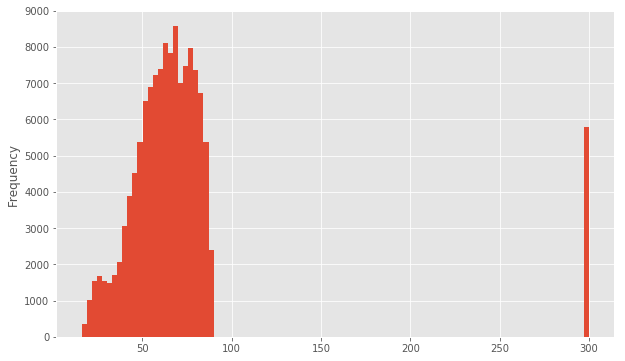

time: 416 ms


In [18]:
len(ABrx_ntnull['icustay_id'].unique())

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
ABrx_16sterile_ntnul['first_admit_age'].sort_values(ascending=True).plot.hist(100)

In [19]:
ABrx_16sterile_ntnul.head()

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,ICU_admit,ICU_disch,los,first_wardid,last_wardid,chartdate,culture_charttime,spec_itemid,spec_type_desc,org_name
0,16,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
1,842,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
2,59177,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
3,59181,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None
4,60474,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,...,2182-11-11 20:02:17,2183-01-15 19:41:21,64.9855,52,52,2182-11-12,2182-11-12 01:50:00,70012,BLOOD CULTURE,None


time: 29.8 ms


### annotating pt who have antibiotics data in cv, mv, or both. 

In [20]:
# updated 4/11/18  
cv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='carevue']['subject_id'].unique()
mv_pts= ABrx_16sterile_ntnul[ABrx_16sterile_ntnul['dbsource']=='metavision']['subject_id'].unique()

both_pts= []
for pt in ABrx_16sterile_ntnul["subject_id"].unique():
    if pt in cv_pts and pt in mv_pts:
        both_pts.append(pt)
        
#need to annotate in pt_db_association column
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='carevue','pt_ab_db']='cv_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='metavision','pt_ab_db']='mv_ab'
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'dbsource']=='both','pt_ab_db']='both_marking_ab' 
ABrx_16sterile_ntnul.loc[ABrx_16sterile_ntnul.loc[:,'subject_id'].isin(both_pts),'pt_ab_db']='cv/mv_ab'


ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul.sort_values('startdate').drop_duplicates('subject_id')
ABrx_16sterile_ntnul_pts = ABrx_16sterile_ntnul_pts[['subject_id','Antibiotics','dob','gender','first_admit_age','pt_ab_db']]
#pt_ab_age_df = pd.merge(pt_sterile16_list, ABrx_merged_16sterile_ntnul_pts[['subject_id','pt_ab_db']], left_on= 'subject_id', right_on='subject_id',how = 'inner') 

ABrx_16sterile_ntnul_pts['pt_ab_db'].value_counts() #total: 14903

#numbers before regenerating dataset (filtered for only culture dates within icu date windows -> pt has any sterile culture)
# cv_ab              10394 -> 9639 -> 9629 -> 8187  for only blood cultures
# mv_ab               9993 -> 9243 -> 9228 _> 7681
# cv/mv_ab             777 -> 684 -> 682 -> 576
# both_marking_ab       72 -> 72 -> 72 -> 68
# Name: pt_ab_db, dtype: int64

cv_ab              9658
mv_ab              9247
cv/mv_ab            683
both_marking_ab      72
Name: pt_ab_db, dtype: int64

time: 902 ms


### restricting df rows to only those with 24hr associated AB and SC
- marking first ab date within 24hr of sterile site culture
- restricting to only rows where the ab's are at or after the first date (first date = first ab is within 24 hour of culture.)
- note: the t_end consec is established in the next set to determine consecutive ab days.

In [21]:
def AB_SC_associated_time_annotation(ABrx_16sterile_ntnul):
    
    """
    fxn: annotates antibiotic dataframe with t_0 and t_end for each patient.
    ##t0 is the first ab date in icu associated within 24 hours of sterile site culture
    ##t_end is the longest duration ab associated with t0
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output: ABrx_16sterile_ntnul annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture. 
    """
    
    #boolean criteria where delta between the AB startdate and culture_charttime is less than 24hr
    lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
        ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'

    #column annotating the delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_16sterile_ntnul['ab_culture_delta'] = (
        pd.to_datetime(ABrx_16sterile_ntnul['startdate']) 
        - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])
    )

    #df of all rows where delta between the AB startdate and culture_charttime is less than 24hr
    ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]
    
    #annotating t_0: the first ab date in icustay associated within 24 hours of sterile site culture
    ABrx_ab24hrdelta['t_0']= ABrx_ab24hrdelta.groupby('icustay_id')['startdate'].transform(lambda x: min(x))

    
    ABrx_16sterile_ptAB24startdate= ABrx_ab24hrdelta[['icustay_id','t_0']].drop_duplicates('icustay_id')

    ABrx_16sterile_ptAB24enddate= ABrx_ab24hrdelta[
        ABrx_ab24hrdelta['startdate']==ABrx_ab24hrdelta[
            't_0']].sort_values(
                ['subject_id','icustay_id','enddate'], ascending=[True,True,False]).drop_duplicates('icustay_id')


    #adding t_0 and t_end to ABrx_16sterile_ntnul by merging w/ AB24startdate and enddate above
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24startdate,
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    ABrx_16sterile_ntnul= (
        pd.merge(
            ABrx_16sterile_ntnul,
            ABrx_16sterile_ptAB24enddate[['icustay_id','enddate']],
            left_on= 'icustay_id', right_on='icustay_id', how = 'left')
    )
    #renaming columns for ease
    ABrx_16sterile_ntnul=(
        ABrx_16sterile_ntnul.rename(index=str, columns={'enddate_x':'enddate',"enddate_y":"t_end"})
    )
    return(ABrx_16sterile_ntnul)


def AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul):
    
    """
    fxn: restrict the input dataframe to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    
    input: the merged dataframe consisting of all antibiotic data, hospital, icu admission, and patient data 
    for patients >=16yo w/ a sterile site culture and no null ICUstay_id's (named ABrx_16sterile_ntnul).
    
    output:  ABrx_16sterile_ntnul (updated) annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture.
    
    ABrx_16sterile_ntnul2 (updated) annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
    within 24 hours of a sterile site culture (same as ntnul above) AND filtered to only rows where the ab's are at or after the first date where an ab is within 24 hour of culture.
    this should be df where all ab_icustart dates are greater than or equal to the first 24 hour associated ab start date after icu admission.
    """
    ABrx_16sterile_ntnul = AB_SC_associated_time_annotation(ABrx_16sterile_ntnul)
    
    ABrx_16sterile_ntnul2=(
        ABrx_16sterile_ntnul.loc[
            ABrx_16sterile_ntnul['startdate'] >= ABrx_16sterile_ntnul['t_0']]
    )
    ABrx_16sterile_ntnul2['t_end_consec']=ABrx_16sterile_ntnul2['t_end']
    ABrx_16sterile_ntnul2['abduration']= (
        pd.to_datetime(ABrx_16sterile_ntnul2['enddate'])
        - pd.to_datetime(ABrx_16sterile_ntnul2['startdate'])
    )

    ABrx_16sterile_ntnul2.sort_values(['subject_id','startdate'])
    return(ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2) #this should be df where all ab_icustart dates are greater than or 
                                  #equal to the first 24 hour associated ab start date after icu admission.

time: 67.3 ms


In [22]:
ABrx_16sterile_ntnul, ABrx_16sterile_ntnul2= AB_SC_associated_cohort_restriction(ABrx_16sterile_ntnul)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

time: 4.83 s


In [23]:
ABrx_16sterile_ntnul.head()
len(ABrx_16sterile_ntnul)

130880

time: 2.86 ms


In [24]:
len(ABrx_16sterile_ntnul2)
ABrx_16sterile_ntnul2.head()

,Unnamed: 0,row_id,subject_id,hadm_id,icustay_id,startdate,enddate,drug_type,drug,drug_name_poe,...,culture_charttime,spec_itemid,spec_type_desc,org_name,pt_ab_db,ab_culture_delta,t_0,t_end,t_end_consec,abduration
0,16,2366833,24915,194424,267059.0,2182-12-10,2182-12-10,MAIN,Daptomycin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,27 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,0 days
1,842,2366088,24915,194424,267059.0,2182-11-29,2182-12-24,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,16 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,25 days
2,59177,2366064,24915,194424,267059.0,2182-11-17,2182-11-20,MAIN,Vancomycin HCl,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,4 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,3 days
3,59181,2366065,24915,194424,267059.0,2182-11-17,2182-11-29,MAIN,Imipenem-Cilastatin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,4 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,12 days
4,60474,2367574,24915,194424,267059.0,2183-01-12,2183-01-15,MAIN,Levofloxacin,NaN,...,2182-11-12 01:50:00,70012,BLOOD CULTURE,None,cv_ab,60 days 22:10:00,2182-11-12,2182-11-26,2182-11-26,3 days


time: 22.2 ms


In [25]:
###Algorithm to squash all dates into a timespan that covers the continuous days on any AB starting at the first ab within 24 hour of a sc
@memory.cache
def update_t_end(t):  
    t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'t_end_consec']= t.loc[
        ((pd.to_datetime(t['startdate']) <= pd.to_datetime(t['t_end_consec'])) & (
            pd.to_datetime(t['enddate']) >= pd.to_datetime(t['t_end_consec']))),'enddate']
    t['t_end_consec']= t.groupby('icustay_id')['t_end_consec'].transform(lambda x: max(x))
    t['abduration']= pd.to_datetime(t['t_end_consec'])-pd.to_datetime(t['t_0'])
    return(t)


time: 15.2 ms


### Calculate and annotate the total continuous time on ANY antibiotic during each patient’s icu stay

In [ ]:
def t_end_consec_annotation(ABrx_16sterile_ntnul2):
    """
    input: df, 
    designed for ABrx_16sterile_ntnul2-this should be df where all ab_icustart dates are greater than or equal to the first 24 hour associated ab start date after icu admission.

    output: ABrx_16sterile_ntnul_final: ABrx_16sterile_ntnul2 with t_start and t_end updated. each antibiotic 
    
    ABrx_16sterile_ntnul_finalPT: final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed. 
    said another way, using the prescription antibiotic list and the list of dates of ssc cultures, building patient list that annotates first ab within 24 hr of sc for each pt. 
    """
        
    important_columns=[
        'subject_id',
        'icustay_id',
        'hadm_id', #added 8/14/18
        'drug',
        'culture_charttime',
        'ab_culture_delta',
        'startdate',
        'enddate',
        't_0',
        't_end',
        'abduration',
        't_end_consec',
        'ICU_admit',
        'ICU_disch'
    ]
    ABrx_16sterile_ntnul_final= ABrx_16sterile_ntnul2[important_columns].sort_values( 
        ['subject_id',
         'hadm_id', #added 8/14/18
         'icustay_id',
         'startdate',
         'abduration'], ascending=[True,True, True, False, True])  #added another True 8/14/18
    
    #updating t_end consec by running my update_t_end algorithm 5 times. 
    i=1
    while i<6:
        ABrx_16sterile_ntnul_final= update_t_end(ABrx_16sterile_ntnul_final)
        i+=1
    
    #making a final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed
    ABrx_16sterile_ntnul_finalPT = ABrx_16sterile_ntnul_final.sort_values(
        ['hadm_id','icustay_id','startdate'], ascending=[True,True,True]).drop_duplicates('hadm_id')  #changed subject_id to hadm_id on 8/14/18
    ABrx_16sterile_ntnul_finalPT = ABrx_16sterile_ntnul_finalPT.sort_values(
        ['hadm_id','icustay_id','startdate'], ascending=[True,True,True]).drop_duplicates('icustay_id')  #changed subject_id to hadm_id on 8/14/18
    
    return(ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT)


time: 18.2 ms


In [ ]:
ABrx_16sterile_ntnul_final, ABrx_16sterile_ntnul_finalPT= t_end_consec_annotation(ABrx_16sterile_ntnul2)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Persisting input arguments took 1.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


In [ ]:
#all patients with appropriate antibiotic timing in relation to sterile culture. 
print(ABrx_16sterile_ntnul_finalPT['abduration'].describe())

(ABrx_16sterile_ntnul_finalPT['abduration'] / pd.Timedelta(days=1)).hist(bins = 63)#bins=xrange(min(compare_table['date delta']), 120, 1))
plt.xlabel(' time on antibiotics (days)')
plt.ylabel('# of icustay_ids');

print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']> pd.Timedelta(days=7),'abduration'].value_counts(bins=1))
#4/24: n=12613. 
#7/6/18: n=12611

In [ ]:
#ABrx_16sterile_ntnul_finalPT.head()
ABrx_16sterile_ntnul_finalPT.loc[:,'hadm_id'].value_counts().describe()

In [ ]:
ABrx_16sterile_ntnul_finalPT.loc[:,'icustay_id'].value_counts().describe()

# adding in DOD
we realized later on that we need dod in our spreadsheet. below adds it to our final patient set. 

In [ ]:
#task 3, dod
#issue: there is a differential on 155 ssd's. 

#(DOD_HOSP) or the social security database (DOD_SSN).


list_pt =ABrx_16sterile_ntnul_finalPT['subject_id'].unique()
dod_sql = query_schema + """
SELECT subject_id, DOD_HOSP, DOD_SSN 
from mimiciii.patients
WHERE subject_id in {}
""".format(tuple(list_pt))     
dod_df = pd.read_sql_query(dod_sql,conn)

dod_df['delta']= dod_df['dod_hosp']- dod_df['dod_ssn']
#dod_df.loc[dod_df.loc[:,'delta'].notnull()!=timedelta(days=0),:]

dod_df2= dod_df[dod_df['delta'].notnull()]
dod_df2.loc[dod_df2.loc[:,'delta']!= timedelta(days=0),:]

In [ ]:
# categorize pt into ab bins

In [ ]:
#task 4, categorize every patient into ab bins
# group 1= partial= is antibiotics for 3 days or less
# group 2= full= is antibiotics for 5 or more days or died during ab course

ABrx_16sterile_ntnul_finalPT = pd.merge(
    ABrx_16sterile_ntnul_finalPT,
    dod_df[['subject_id','dod_hosp','dod_ssn']],
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

ABrx_16sterile_ntnul_finalPT['ab_course']=''

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] <= pd.Timedelta(days=4),'ab_course']='partial' #days changed from 3 to 4 on 7/16/18 based on Nelson's suggestion

ABrx_16sterile_ntnul_finalPT.loc[
    ABrx_16sterile_ntnul_finalPT.loc[:,'abduration'] >= pd.Timedelta(days=5),'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_hosp'])),
    'ab_course']='full'

ABrx_16sterile_ntnul_finalPT.loc[
    ((pd.to_datetime(ABrx_16sterile_ntnul_finalPT['t_end_consec'])+ pd.DateOffset(1)) 
     >= pd.to_datetime(ABrx_16sterile_ntnul_finalPT['dod_ssn'])),
    'ab_course']='full'

print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='full','subject_id'].unique())) #5485 full patients -> 6188 full on 7/6
print(len(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'ab_course']=='partial','subject_id'].unique())) #5949 partial patients -> 5305 partial on 7/6


In [ ]:
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']<= pd.Timedelta(days=7),'abduration'].value_counts())
print(
    ABrx_16sterile_ntnul_finalPT.loc[
        ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']>= pd.Timedelta(days=8),'abduration'].value_counts(bins=1))

In [ ]:
##not sure the purpose of this:
#ABrx_16sterile_ntnul_finalPT.loc[ABrx_16sterile_ntnul_finalPT.loc[:,'abduration']== pd.Timedelta(days=0),:]

In [ ]:
ABrx_16sterile_ntnul_finalPT['icustay_id'].nunique() #x12611 subject id's, x12611 icustay id's ->13763 icustay_id
#ABrx_16sterile_ntnul_finalPT['subject_id'].nunique() #11557 subject_id

# Extracting BLOOD Culture results
### accounting for all sterile cultures taken within 72 hours of the first ab. 
4/22/18 (overhauled on 1/25/19(

we now have a by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed. these are only for ab's that have a ssc within 24 hours of starting.
for each patient we have the ab start date (t_0)  and the end of the consecutive ab time window (t_end)

In [ ]:
def SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
                   ssc_sql=sterile_pt_df,
                   blood_only=False,
                   n_days=3,
                   n_day_column='t_0_sc',
                   first_ssc_after_ICU=False,
                   filter_t0_after_icu=False,
                   n_filter_days=4):
    """
    input: ABrx_16sterile_ntnul_finalPT: final by pt spreadsheet where the first ab prescription meeting the 24hr sc window is listed. 
    said another way, using the prescription antibiotic list and the list of dates of ssc cultures, building patient list that annotates first ab within 24 hr of sc for each pt. 
    
    n_days
    sterile_pt_df: the primary sql query df for ssc info from mimic. 
    
    blood_only: option to restrict to only blood cultures
    
    n_days, n_day_column: origionally the criteria was to find cultures within 3 days window of t_0 and t_0_sc, if any were pos then patient was culture pos, else negative. we can sepcify column and day window if we want to look from ICU_admit instead.
    first_ssc_after_ICU: allows option to restrict the culture result output to only those after ICU admission. 
    
    outputs:
    
        all_cultures_pt_df_ab_cohort: all (neg and pos) culture results for patients meeting criteria
        notneg_cultures_pt_df_ab_cohort: just positive culture results for patients meeting criteria
        positive_organisms: all positive organisms found in ssc instances between t_0_sc and n_day_column. 
    """
    
    #option criteria1: to restrict to only blood cultures
    if blood_only == True:
        ssc_sql=(ssc_sql.loc[ssc_sql.loc[:,'spec_type_desc']
                                     .isin(["BLOOD CULTURE",
                                            'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)'])
                                     ,:])
   
    ab_cohort_pt_info = final_abdata_pt_df[['hadm_id','culture_charttime','t_0','ICU_admit','dod_ssn']] #culture charttime is the culture recorded as being within 24 hr of t_0
    
    ##optional criteria2: only patients who started their ab (t_0) within n_filter_days of icu_admit?  -this is to limit to non-2dary infections.
    if filter_t0_after_icu == True:
        n_filter_days= pd.Timedelta('%s days' %(n_filter_days))
        ab_cohort_pt_info['t0_admit_delta']=pd.to_datetime(ab_cohort_pt_info['t_0']) - pd.to_datetime((ab_cohort_pt_info['ICU_admit']))
        ab_cohort_pt_info = ab_cohort_pt_info[ab_cohort_pt_info['t0_admit_delta']<= n_filter_days]
    
    sterile_pt_df_ab_cohort = pd.merge(ssc_sql,
                                       ab_cohort_pt_info ,
                                       left_on='hadm_id',
                                       right_on='hadm_id',
                                       how='inner' ) #adding ['hadm_id','culture_charttime','t_0','ICU_admit','dod_ssn'] onto the culture results for all patients
    
    #making the Null charttime values = to chartdate
    cd= sterile_pt_df_ab_cohort.loc[sterile_pt_df_ab_cohort.loc[:,'charttime'].isna(),"chartdate"]
    sterile_pt_df_ab_cohort.loc[sterile_pt_df_ab_cohort.loc[:,'charttime'].isna(),"charttime"]= cd
    sterile_pt_df_ab_cohort= sterile_pt_df_ab_cohort.rename(columns={'culture_charttime':'t_0_sc'})
    
    #ensuring columns are in datetime format
    sterile_pt_df_ab_cohort['t_0_sc']= pd.to_datetime(sterile_pt_df_ab_cohort['t_0_sc'])
    sterile_pt_df_ab_cohort['charttime']= pd.to_datetime(sterile_pt_df_ab_cohort['charttime'])
    sterile_pt_df_ab_cohort['ICU_admit']= pd.to_datetime(sterile_pt_df_ab_cohort['ICU_admit'])
    #sterile_pt_df_ab_cohort.groupby('hadm_id')['charttime'].transform(lambda x: min(x))#was used to check that culture_charttime is indeed first sc ab within 24 hr of t_0.
    
    ####filtering criteria for all SSC results:######
    
    #optional criteria3: limiting to only rows where ssc was performed after ICU admit.
    if first_ssc_after_ICU ==True:        
        sterile_pt_df_ab_cohort['ssc_admit_delta']= pd.to_datetime(sterile_pt_df_ab_cohort['charttime']) -pd.to_datetime(sterile_pt_df_ab_cohort['ICU_admit'])
        sterile_pt_df_ab_cohort= sterile_pt_df_ab_cohort[sterile_pt_df_ab_cohort['ssc_admit_delta']>pd.Timedelta('0 days')] #only rows where culture occured in icu. 
    
    
    #criteria1: only results at or after the first positive within 24 hr of t_0
    criteria1= sterile_pt_df_ab_cohort['charttime']>=sterile_pt_df_ab_cohort['t_0_sc'] #t_0_scis the first ssc within 24 hr of t_0
    
    #criteria2: only results within n_days of n_day_column
    t_window= pd.Timedelta('%s days' %(n_days))
    criteria2= (sterile_pt_df_ab_cohort['charttime'])<=(sterile_pt_df_ab_cohort[n_day_column]+ t_window) #ensure it's within n_days of n_day_column (default = culture_chartime, but can switch to t_admit)

    
    all_cultures_pt_df_ab_cohort = sterile_pt_df_ab_cohort[criteria1 & criteria2].drop_duplicates(['hadm_id', 'org_name', 'charttime'])
    notneg_cultures_pt_df_ab_cohort= all_cultures_pt_df_ab_cohort[all_cultures_pt_df_ab_cohort['org_name'].notnull()].sort_values(['hadm_id','charttime'], ascending=[True, False]) #16022 rows... 6619 hadm_id
    positive_organisms= notneg_cultures_pt_df_ab_cohort['org_name'].value_counts()
    
    
    final_pt_df= all_cultures_pt_df_ab_cohort[['subject_id','hadm_id','t_0_sc']] 
       
    return(all_cultures_pt_df_ab_cohort,notneg_cultures_pt_df_ab_cohort,positive_organisms, final_pt_df)

In [ ]:
# #for origional cohort:

# all_cultures_pt_df_ab_cohort, notneg_cultures_pt_df_ab_cohort, positive_organisms, final_pt_df1 = SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
#                                                                                                    ssc_sql=sterile_pt_df,
#                                                                                                    blood_only=False,
#                                                                                                    n_days=3,
#                                                                                                   n_day_column='t_0_sc',
#                                                                                                   first_ssc_after_ICU=False)

In [ ]:
# #for testing:
# all_cultures_pt_df_ab_cohort, notneg_cultures_pt_df_ab_cohort, positive_organisms, final_pt_df1 = SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
#                                                                                                    ssc_sql=sterile_pt_df,
#                                                                                                    blood_only=False,
#                                                                                                    n_days=3,
#                                                                                                   n_day_column='t_0_sc',
#                                                                                                   first_ssc_after_ICU=True)


In [ ]:
#for PAII cohort:
all_cultures_pt_df_ab_cohort, notneg_cultures_pt_df_ab_cohort, positive_organisms, final_pt_df1 = SSC_for_cohort(final_abdata_pt_df=ABrx_16sterile_ntnul_finalPT,
                                                                                                   ssc_sql=sterile_pt_df,
                                                                                                   blood_only=True,
                                                                                                   n_days=3,
                                                                                                  n_day_column='t_0_sc',
                                                                                                  first_ssc_after_ICU=True,
                                                                                                  filter_t0_after_icu=True,
                                                                                                   n_filter_days=4)

In [ ]:
all_cultures_pt_df_ab_cohort['hadm_id'].nunique() #15203 -> 12388  if we choose only after ICU admit

#9129-> 8731 with icu delta filter

 From what I hear you saying, we could look at the first positive infection culture after the "suspected infection" clock starts (t_0) up through 72 hours (t_72). for each patient, we find their positive_ssc_t0 and collect data between t_0 and positive_ssc_t0+72. the idea behind this is that we want to use the data starting from the point in time they are suspected of having an infection (ie when ab start) up through 12 hours after they get their first positive culture taken.  is this correct?
 
 * no collect data from culture start to 

In [ ]:
#big question to answer, all sterile cultures within 48 hours of what? i am going to set timeframe for each patient: 
#look at all cultures between the first SC within 24 hour of ab and up to 48 hours after first ab dose in ICU.
#this means the max i will cover is 72 hours. 

In [ ]:
list(ABrx_16sterile_ntnul)
ABrx_16sterile_ntnul['subject_id'].nunique() #19000 ->16512 1/21/19

In [ ]:
###historical record, replaced with SSC_for_cohort. which has more simple and interpretable code. 


# def pt_sc_results(ABrx_16sterile_ntnul):
    
#     """
#     input: ABrx_16sterile_ntnul (updated) annotated with t_0 and t_end for the FIRST instance of an ab being given in the icu 
#     within 24 hours of a sterile site culture.
    
#     outputs:
    
#         patients_sc_dates: 
#         final_pts_window_sc: all sterile site culture instances between t_0_sc and t_end_sc for patients 
#         positive_organisms: all positive organisms found in ssc instances between t_0_sc and t_end_sc. 
#     """
    

#     #filtering to all rows where the patient has a ab and ssc within 24 hr.
#     lessthan24hr= abs(pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(
#         ABrx_16sterile_ntnul['culture_charttime'])) <='24:00:00'
#     ABrx_ab24hrdelta= ABrx_16sterile_ntnul.loc[lessthan24hr]

    
#     ABrx_ab24hrdelta['t_0_sc']= ABrx_ab24hrdelta.groupby('icustay_id')['culture_charttime'].transform(lambda x: min(x))
#     ABrx_ab24hrdelta['t_end_sc']= pd.to_datetime(ABrx_ab24hrdelta['t_0']) + timedelta(days=3)

#     #filtering it to only essential info, and only for patients who made it through all other criteria. 
#     patients_sc_dates= ABrx_ab24hrdelta[['subject_id','icustay_id','hadm_id','t_0_sc','t_end_sc']].drop_duplicates('icustay_id')
    
#     #filtering to only pt in ABrx_16sterile_ntnul_finalPT
#     patients_sc_dates= patients_sc_dates.loc[
#         patients_sc_dates.loc[:,'icustay_id'].isin(
#             list(ABrx_16sterile_ntnul_finalPT['icustay_id'].unique())),:
#     ] 

#     final_pts_all_sc= sterile_pt_df.loc[sterile_pt_df.loc[:,'hadm_id'].isin(list(patients_sc_dates['hadm_id'].unique())),:] 
#     final_pts_all_sc= pd.merge(final_pts_all_sc,patients_sc_dates[['hadm_id','t_0_sc','t_end_sc']],
#                                left_on= 'hadm_id',
#                                right_on='hadm_id',
#                                how = 'inner')

#     #pd.to_datetime(ABrx_16sterile_ntnul['startdate']) - pd.to_datetime(ABrx_16sterile_ntnul['culture_charttime'])

#     #all blood culture instances between t_0_sc and t_end_sc for patients     
#     final_pts_window_sc= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
#                     (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
#                     final_pts_all_sc['org_name'].notnull()] 
    
#     final_pts_window_sc= final_pts_window_sc.drop_duplicates(['hadm_id', 'org_name', 'charttime'])


#     positive_organisms= final_pts_all_sc[(final_pts_all_sc['charttime']>=final_pts_all_sc['t_0_sc']) &
#                     (final_pts_all_sc['charttime']<=final_pts_all_sc['t_end_sc']) &
#                     final_pts_all_sc['org_name'].notnull()]['org_name'].value_counts()
    
#     return(patients_sc_dates, final_pts_window_sc, positive_organisms)

In [ ]:
#patients_sc_dates, final_pts_window_sc, positive_organisms = pt_sc_results(ABrx_16sterile_ntnul)

In [ ]:
#final_pts_window_sc #~3000 with only blood, 8582 with all

In [ ]:
# print(final_pts_window_sc['hadm_id'].nunique()) #wow only 2107->2156 hadm_id's within t_0 and t_42->t_72 a positive blood culture?

###grr wtf, somehow my n went down to 2074 even after expanding criteria to be t_0 include all sc, and just find positive BLOOD cultures.
###how does thsi shit happen?

In [ ]:
#print(len(patients_sc_dates), len(final_pts_window_sc), len(positive_organisms))

# SC culture filtering and ab death dose adjust

###  import the annotated culture list, exclude the excludes, and get an # of positives for the staphs.

08/16/18 qc. after chaning the patient criteira, i found that a lot of patients with multiple icustays now have identical culture results. need to explore where this is occuring.




In [ ]:
notneg_cultures_pt_df_ab_cohort.loc[notneg_cultures_pt_df_ab_cohort.loc[:,'hadm_id']==169392, :] #13

In [ ]:
#all sterile site culture instances between t_0_sc and t_end_sc for patients annotated.
#need further processing to make a by patient +/- within t_0_sc and t_end_sc call. 
##details: all staph infections require 2 positive cultures in time window. 
annotated_sc = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/positive_organisms_4-24-18_NSPComments.csv')
#organisms that grew in sc in our patients. annotation key:
#1= eliminate
#0= keep
#2= requires 2 positives in same patient within the timewindow. 
notneg_cultures_pt_df_ab_cohort= pd.merge(notneg_cultures_pt_df_ab_cohort,annotated_sc[['org_name','Eliminate']],
                              left_on= 'org_name',
                              right_on='org_name',
                              how = 'left')



In [ ]:
#final_pts_window_sc
notneg_cultures_pt_df_ab_cohort[notneg_cultures_pt_df_ab_cohort['hadm_id']==112218]

# staph_count[staph_count['hadm_id']==112218]


In [ ]:
def sc_pos_filter(notneg_cultures_pt_df_ab_cohort):
    #coag_neg_staph_counting:
    staph_cultures= notneg_cultures_pt_df_ab_cohort.loc[notneg_cultures_pt_df_ab_cohort.loc[:,'Eliminate']==2,:].drop_duplicates(['hadm_id', 'org_name', 'charttime'])

    staph_count = staph_cultures.groupby('hadm_id')['hadm_id'].agg(["count"]).rename(columns={'count': 'staph_count'})
    staph_count= pd.DataFrame(staph_count).reset_index()

    merged = pd.merge(
        notneg_cultures_pt_df_ab_cohort,
        staph_count, #changed  subject_id to hadm_id 08/16/2018
        left_on= 'hadm_id', #changed  subject_id to hadm_id 08/16/2018
        right_on='hadm_id', #changed  subject_id to hadm_id 08/16/2018
        how = 'left')

    #combining staph, positive org and neg org criteria to make only positive org list. 
    criteria1= merged.loc[:,'Eliminate']==0
    criteria2= merged.loc[:,'staph_count']>1
    merged= merged[criteria1|criteria2] #all unique values betwen the two
    merged= merged[merged['Eliminate']!=1] #eliminate =1 means to get rid of culture result, ie likely contamination
    #merged
    return(merged)

pos_cultures_pt_df_ab_cohort = sc_pos_filter(notneg_cultures_pt_df_ab_cohort) #31108 #all pos sc for patients with any positives.
pos_cultures_pt_df_ab_cohort= pos_cultures_pt_df_ab_cohort.drop_duplicates(['hadm_id', 'org_name', 'charttime']) #removing duplicates, not sure why dups exist

pos_cultures_pt_df_ab_cohort_list= list(pos_cultures_pt_df_ab_cohort['hadm_id'].unique()) #changed to hadm_id 08/16/2018


In [ ]:
pos_cultures_pt_df_ab_cohort.sort_values(['hadm_id', 'org_name', 'charttime']).head(10)

###  Gram +/- categorization

In [ ]:
###gram_categorizing +/-
gram_categorizing= pd.DataFrame(notneg_cultures_pt_df_ab_cohort['org_name'].value_counts().reset_index())
date='21012019'
pd.DataFrame(gram_categorizing).to_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_gram_categorizing.csv" %date) #final cohort database n=11493 subject_id’s (7/6/18)


In [ ]:
annotated_gram = pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/21012019_gram_categorizing-nsp.csv')
#organisms that grew in sc in our patients. annotation key:
#1= gram +
#0= gram -
#2= mycobacterium or other 
pos_cultures_pt_df_ab_cohort= pd.merge(pos_cultures_pt_df_ab_cohort,annotated_gram[['org_name','Gram_pos']],
                              left_on= 'org_name',
                              right_on='org_name',
                              how = 'left')

#notneg_cultures_pt_df_ab_cohort.drop(i)

In [ ]:
#final_pts_window_pos_sc.loc[final_pts_window_pos_sc.loc[:,'staph_count']>2,:]

In [ ]:
#len(final_pts_window_pos_sc) #removed duplicate ['hadm_id', 'org_name', 'charttime'] =2848

In [ ]:
len(pos_cultures_pt_df_ab_cohort.drop_duplicates(['hadm_id', 'org_name', 'charttime']))

In [ ]:
pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['Gram_pos'].apply(lambda x: min(x)).reset_index()

### make list of all patients positive, negative sc cultures

In [ ]:
#5/2/18, makes list of all pos culture result and specimen types for annotation on final df
#organism name

pos_cultures_pt_df_ab_cohort2 = pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['Gram_pos'].apply(lambda x: min(x)).reset_index()

pos_cultures_pt_df_ab_cohort3 = pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['org_name'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
pos_cultures_pt_df_ab_cohort3 = pos_cultures_pt_df_ab_cohort3.rename(index=str, columns={'org_name':'org_list'})

#specimen type
pos_cultures_pt_df_ab_cohort4 = pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['spec_type_desc'].apply(', '.join).reset_index() #changed to hadm_id from subject_id 08/16/2018
pos_cultures_pt_df_ab_cohort4 = pos_cultures_pt_df_ab_cohort4.rename(index=str, columns={'spec_type_desc':'spec_type_list'})

#now have a column with all positive culture results and specimen types

In [ ]:
#first dates for positive culture within criteria window, else first culture within criteria window.
first_criteria_pos_culture= pos_cultures_pt_df_ab_cohort.groupby('hadm_id')['charttime'].apply(lambda x: min(x)).reset_index()
first_criteria_any_culture= all_cultures_pt_df_ab_cohort.groupby('hadm_id')['charttime'].apply(lambda x: min(x)).reset_index()

first_criteria_pos_culture= first_criteria_pos_culture.rename(index=str, columns={'charttime':'pos_charttime'})
first_criteria_any_culture= pd.merge(first_criteria_any_culture, first_criteria_pos_culture, left_on='hadm_id', right_on='hadm_id', how='left')
first_criteria_any_culture['first_pos_else_neg_ssc']= first_criteria_any_culture['pos_charttime']
neg_else = first_criteria_any_culture['first_pos_else_neg_ssc'].isnull()
first_criteria_any_culture.loc[neg_else, 'first_pos_else_neg_ssc'] = first_criteria_any_culture.loc[neg_else, 'charttime']
first_criteria_any_culture=first_criteria_any_culture[['hadm_id','first_pos_else_neg_ssc']]

# FINAL cohort generation
08/16/18 qc. after chaning the patient criteira, i found that a lot of patients with multiple icustays now have identical culture results. need to explore where this is occuring.

1) make final ab categorizations
2) make final patient list with ab, sterile site culture results and final binning

## this is final patient dataframe with n patients with following criteria:
* antibiotic in PRESCRIPTION table within 24 hours of an sterile site culture in MICROBIOLOGYEVENTS table
* who are over the age of 16. the culture result (annotated below) and antibiotic course (annotated below) are 
* also annotated on this. these patients were then categorized into 4 categories:
 * 'C_neg/A_partial'
 * 'C_neg/A_full'
 * 'C_pos/A_full'
 * 'C_pos/A_partial'
#### notes:
* 1)i considered any patient who had their last antibiotic date at or after either 
#hospital or ssn DOD as "full" ab course. 

* 2) i considered any patients who had the listed staph infections positive at 
#any of their sterile site cultures within the 72hour ab timewindow as a culture 'positive' patients. 

* 3) time window for positive culture is defined in SSC_for_cohort (default 72hr from t_0_sc)



##### pd.DataFrame(final_pt_df2).to_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/06072018_final_pt_df2.csv') #date may change

In [ ]:
#4/30/18: ASSEMBLING A FINAL PT LIST. 
#final_pts_window_pos_sc_list= list(final_pts_window_pos_sc['subject_id'].unique())
final_pt_df=0
final_pt_df = final_pt_df1#all_cultures_pt_df_ab_cohort[['subject_id','hadm_id','t_0_sc']]  #needs icustay_id

final_pt_df = pd.merge(
    final_pt_df,
    ABrx_16sterile_ntnul_finalPT[['hadm_id','icustay_id','ab_course', 't_0','t_end_consec','ICU_admit']], #testing the ICU_admit with this
    left_on= 'hadm_id', #changed from subject_id
    right_on='hadm_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    dod_df2,
    left_on= 'subject_id',
    right_on='subject_id',
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    pos_cultures_pt_df_ab_cohort3,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    pos_cultures_pt_df_ab_cohort4,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    pos_cultures_pt_df_ab_cohort2,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df = pd.merge(
    final_pt_df,
    first_criteria_any_culture,
    left_on= 'hadm_id', #changed to hadm_id from subject_id 08/16/18
    right_on='hadm_id', #changed to hadm_id from subject_id 08/16/18
    how = 'left')

final_pt_df= final_pt_df.rename(index=str, columns={'delta':'dod_delta'})
final_pt_df['sc_result']=''
final_pt_df['final_bin']=''

#task 1, marking of all patients positive, negative sc cultures
final_pt_df.loc[final_pt_df.loc[:,'hadm_id'].isin(pos_cultures_pt_df_ab_cohort_list),'sc_result']='positive' #changed to hadm_id from subject_id 08/16/18
final_pt_df.loc[final_pt_df.loc[:,'sc_result']!='positive','sc_result']='negative'
#1 is positive, 0 is negative

#FINAL_PT_LIST=list(final_pt_df['subject_id'].unique())
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_partial'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='negative'),'final_bin']='C_neg/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='full') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_full'
final_pt_df.loc[(final_pt_df['ab_course']=='partial') 
                   & (final_pt_df['sc_result']=='positive'),'final_bin']='C_pos/A_partial'

#len(list(final_pts_window_pos_sc['subject_id'].unique())) #2630

final_pt_df
final_pt_df2= final_pt_df.loc[final_pt_df.loc[:,'ab_course']!='',:].drop_duplicates('hadm_id')


In [ ]:
final_pt_df2.loc[final_pt_df2.loc[:,'sc_result']=='positive','Gram_pos'].value_counts()

In [ ]:
print(final_pt_df2['icustay_id'].nunique(), final_pt_df2['subject_id'].nunique())

In [ ]:
print(final_pt_df2['final_bin'].value_counts())#11493 

In [ ]:

#4921+3539+481+188
#(481+188)/9129 ##7.3%

n2= 4688 +3422 + 439+ 182

(439+182)/n2 ##7.1%

In [ ]:
final_pt_df2['sc_result'].value_counts() # 8460 669

In [ ]:
final_pt_df2['Gram_pos'].value_counts()

#prior to 72 hour change
- C_neg/A_full       6489 -> 7041 (all culture for pt, only blood for sc results) / 6000 (all cultures)
- C_neg/A_partial    5788 -> 6663 / 5546
- C_pos/A_full       1008 -> 1010 / 2127
- C_pos/A_partial     478 -> 493 / 1534

In [ ]:
final_pt_df2

# assessing t_0, t_0_sc & icuadmit

In [ ]:
# final_pt_df3= final_pt_df2[final_pt_df2['sc_result']=='positive']
# final_pt_df3

In [ ]:
# #t_0_sc is the first culture within 24 hours to t_0. how often is this the first positive cultur date?


# ###################

# #final_pts_window_pos_sc.head()
# first_pos_sc= final_pts_window_pos_sc.groupby('hadm_id')['charttime'].agg(['min']).rename(columns={'min': 'first_pos_ssc'}).reset_index()
# #pd.Dafirst_pos_sc

# test_df= pd.merge(final_pt_df3,first_pos_sc)
# #test_df.head()
# delta= test_df['first_pos_ssc']-test_df['t_0_sc'] #
# delta[delta!='0 days 00:00:00'].describe()
# delta.describe()

In [ ]:
# ##good news is first positive ssc is never sooner than t_0_sc.

# #looking at all sc chartdates vs t_0 for all pt
# #final_pts_window_pos_sc

# all_sc_and_t0=pd.merge(final_pts_window_pos_sc,
#          ABrx_16sterile_ntnul_finalPT[['hadm_id','ab_course', 't_0','t_end_consec','ICU_admit']],
#          left_on='hadm_id',
#          right_on='hadm_id',
#          how='left')

# all_sc_and_t0['sc_t0_delta']= pd.to_datetime(all_sc_and_t0['charttime']) -pd.to_datetime(all_sc_and_t0['t_0'])
# all_sc_and_t0['sc_admit_delta']= pd.to_datetime(all_sc_and_t0['charttime']) -pd.to_datetime(all_sc_and_t0['ICU_admit'])
# all_sc_and_t0['t_0_admit_delta']= pd.to_datetime(all_sc_and_t0['t_0']) -pd.to_datetime(all_sc_and_t0['ICU_admit'])

In [ ]:
# all_sc_and_t0['sc_admit_delta'].describe(percentiles=[0.25,0.5,0.6,0.75,0.9]) #the time difference between sterile culture and ICU admission time

# ##the minimum value on this is perplexing, 
# ##it suggests the one patient had their first sc positive culture done about 36 hours PRIOR to being admitted to icu.


In [ ]:
# #this patient had the longest time between their SC and being admitted to ICU. one of the few cases where sc and t_0 started before ICU admit. 
# all_sc_and_t0[all_sc_and_t0['sc_admit_delta']=='-2 days +12:47:05'] #hadm_id 154930
# all_sc_and_t0[all_sc_and_t0['hadm_id']==154930]

In [ ]:
# #how many cases where sc and t_0 started before ICU admit?
# #all_sc_and_t0['t_0_admit_delta']<pd.Timedelta(0)
# #all_sc_and_t0[(all_sc_and_t0['sc_admit_delta']<pd.Timedelta(0))]
# c1=(all_sc_and_t0['sc_admit_delta']<pd.Timedelta(0))
# c2=(all_sc_and_t0['t_0_admit_delta']<pd.Timedelta(0))
# all_sc_and_t0[(c1 & c2)]['hadm_id'].nunique()

# #322/1503 patients where both sc and t_0 started prior to ICU admission... damn... is this a problem?

In [ ]:
# sterile_all_pt_info[sterile_all_pt_info['hadm_id']==154930].drop_duplicates(['hadm_id','culture_charttime','ICU_admit' ])[[
#     'hadm_id','culture_charttime','first_wardid','ICU_admit' ,'hosp_admit', 'admission_location','admission_type',]]

In [ ]:
# all_sc_and_t0['sc_t0_delta'].describe() #about 1/2 of the patients got their bacterial cutlure 
# ## average is 1.5hours after culture ab were started (but rounding error makes this approx)

In [ ]:
#average time between 

#all_sc_and_t0['t_0_admit_delta'].describe(percentiles=[0.25, 0.5, 0.75, 0.9]) #the time difference between t_0 and ICU admission time
## looks like lowest delta suggests the earliest t_0 occured 12 hours before admission time (though again this is likely lower due to rounding). 
## average is 10.5 hours after admission ab were started

##need to collapse to first positive ssc 
###NOTE, I WILL NEED TO COME BACK TO THIS IN THE FUTURE TO PRIORITIZE GRAM + IF THERE ARE 2 POSITIVE SSC

#### few concerns:
* about 1/2 of the patients got their first positive bacterial cutlure performed prior to the t_0 date.
 * this can be a big deal if it happened too far BEFORE, it could bea big deal
* in about 60% of icustay_id's, the sterile culture occured before they were admitted to the ICU. 
* similarly: 322/1503 patients where both first positive ssc and t_0 (ab start date) occured prior to ICU admission (within 24 hours)... these are likely transfer patients
 * note: the t_0 date is a date, and not a time, so this limits how accurate we can be about the ab start date comparison. howver admission time and culture time have time resolution.
* patients may have more than 1 positive culture within time window, should I prioritize certain ones over others?
* some patients may have been transfered in 


In [ ]:
##looking at first pos sc


In [ ]:
# #final_pts_window_pos_sc.head()
# first_pos_sc= final_pts_window_pos_sc.groupby('hadm_id')['charttime'].agg(['min']).rename(columns={'min': 'first_pos_ssc'}).reset_index()
# #pd.Dafirst_pos_sc

# test_df= pd.merge(final_pt_df3,first_pos_sc)
# #test_df.head()
# delta= test_df['first_pos_ssc']-test_df['t_0_sc'] #
# delta[delta!='0 days 00:00:00'].describe()
# delta.describe()


In [ ]:
# ##all info for first pos ssc

# ##need to collapse to first positive ssc 
# ###NOTE, I WILL NEED TO COME BACK TO THIS IN THE FUTURE TO PRIORITIZE GRAM + IF THERE ARE 2 POSITIVE SSC

# ###there's a few concerns: 
# ###1:
# first_sc_and_t0= all_sc_and_t0.groupby('hadm_id', as_index=False)['charttime'].agg(['min']).rename(columns={'min': 'first_pos_ssc'}).reset_index()

# first_sc_and_t0 =pd.merge(first_sc_and_t0,
#          all_sc_and_t0,
#          left_on=['hadm_id','first_pos_ssc'],
#          right_on=['hadm_id','charttime'])

### stats for first positive ssc

In [ ]:
# ###stats for first positive sc. 
# first_sc_and_t0['sc_t0_delta'].describe()

In [ ]:
#do i need to grab clinical data in previous project between icu admit and t_0 +72?
##no

In [ ]:
# first_sc_and_t0[first_sc_and_t0['t_0_admit_delta']>pd.Timedelta('3 day')] #89

In [ ]:
# ##blood cultures rather than all ssc are for cleaner dataset.

# first_sc_and_t0
# #look for first positive blood culture AFTER ICU ADMISSION. 

# all_sc_and_t0_icu=all_sc_and_t0[(all_sc_and_t0['charttime']- all_sc_and_t0['ICU_admit'])>pd.Timedelta('0 day')]
# #1700 -> 1116 rows if looking at only positive cultures within ICU. 
# #find clinical data 12-24 hours after the first positive blood culture in icu. 
# #need to dig through clinical data and see which variables i may need to extract. 
# ##find the avg time between icu admit and first positive blood culture in icu being obtained. 

# (all_sc_and_t0_icu['charttime']- all_sc_and_t0_icu['ICU_admit']).describe()

# ##for those who have blood culture obtained, for those who are pos what kind, and if not then -. 

# ##clinical use case: we know that some ppl have positive infections, 
# ##and for those who would like to taior their ab to targeted towards type of infection.
# ##if they ar epositive, what is the likelyhood of the bacteria being positive?
# ## bayesian hierarchial model: first model +/- (multilevel prediction model)
# ##second model: for pos gram+ or gram -. 


# cohort generated above

dr luo request:

It would also be good to add the start and end time for the antibiotics. --DONE


Dr. Nelson request:

 1)provide an extra column with the DOD. --DONE
 
 2)one with the first positive culture results (the actual value, as in “Enteroccous Faecalis”, etc.) for those with positive cultures, 
 
 3)the type of culture (eg. urine, blood, etc.).

In [ ]:
# #5/15/18 to do, regenerate this for our cohort to get count of sterile site cultures. 
# #breakdown the 1345 pts cultures, 
# #if a patient has multiple culture types within 24 hr peroid, would be nice to know which are +/-. 
# #more informative to know if pt was ever pos for bloodculture.

# #Look at distribution of all cultures within the 24 hour mark. 

# %pylab inline
# pylab.rcParams['figure.figsize'] = (10, 6)
# sterile_test_df.spec_type_desc.value_counts().head(20).sort_values(ascending=True).plot.barh()

In [ ]:
# #sc maths

# pa2_final_pt= final_pt_df2[final_pt_df2['sc_result']=="positive"]

# #need to be sure i have currently listd  the first positive ssc date within t_0 to t_72 window.
# ##don't need to collect additional data prior to t_0 for ongoing project. 
# pa2_final_pt

# compiling the dataframes into csv's

In [123]:
date='25012019'

pd.DataFrame(final_pt_df2).to_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_PA_df2.csv" %date) #final cohort database n=11493 subject_id’s (7/6/18)


time: 157 ms


style guide stuff:
    
79 characters is longest a line should be, this is 79 chars:
Address the unique rows issue in the sterile culture. Need to use this to filkter down the staph.

In [ ]:
#last instance of ICU_admit time. 

In [ ]:
#final_pt_df2

In [ ]:
(pd.to_datetime(final_pt_df2['t_0'])-pd.to_datetime(final_pt_df2['ICU_admit'])).describe()

# may need to remove these 5% of patients:
these patients are not likely admitted to icu with suspecision of infection, but rather develop it after t_0

In [ ]:
# final_pt_df2['admit_vs_t_0']= (pd.to_datetime(final_pt_df2['t_0'])-pd.to_datetime(final_pt_df2['ICU_admit']))

# final_pt_df2[final_pt_df2['admit_vs_t_0']>pd.Timedelta('4 day')]

# #535

In [ ]:
# len(final_pt_df2)
# 812/15207

In [ ]:
# final_pt_df2['admit_vs_t_0_td']=final_pt_df2['admit_vs_t_0'].astype(np.timedelta64)

In [ ]:
# final_pt_df2.sort_values('admit_vs_t_0_td')

# final_pt_df2[final_pt_df2['admit_vs_t_0_td']<-1e+14].sort_values('admit_vs_t_0_td')['subject_id'].nunique() #3519/11488 patients have a delta of greater than 2 days of their icustay

